# Writing an Oscillator in PyTorch

In [1]:
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt

We create a new sinusoidal oscillator that is a PyTorch module by inheriting from the
`torch.nn.Module` base class. Our sinusoidal oscillator receives a sequence of amplitude
and angular frequency values, and optionally an initial phase.

The equation for this oscillator is as follows:

$$
y[n] = a[n] * sin(\phi[n])
$$

where $a[n]$ and $\phi[n]$ is amplitude and phase at the $n^\text{th}$ sample. However,
we receive a time-varying frequency as input to our function, so we need to convert that
to time-varying frequency. Recall the relationship between frequency and phase:

$$
\omega = \frac{d\phi}{dt}
$$

Frequency is the derivative of phase. Therefore, phase can be calculated by integrating
frequency (summing in the discrete-time case).

$$
\phi[n] = \phi_0 + \sum_{k=0}^{n}\omega[k]
$$

where $\omega[n]$ is angular frequency at the $n^\text{th}$ sample and $\phi[n]$ is computed
as the sum of all previous frequency values plus an initial phase, $\phi_0$.

In [2]:
class Sinusoid(torch.nn.Module):
    
    def forward(
            self,
            amp: torch.Tensor,                  # Amplitude (batch_size, n_steps)
            omega: torch.Tensor,                # Angular frequency (batch_size, n_steps)
            initial_phase: torch.Tensor = 0.0   # Initial phase (batch_size, 1)
        ) -> torch.Tensor:
        phase = torch.cumsum(omega, dim=1) + initial_phase
        return amp * torch.sin(phase)

In [3]:
sr = 16000
freq = torch.ones(1, sr) * 440
freq = freq * 2 * torch.pi / sr

amp = torch.linspace(1, 0, sr)

osc = Sinusoid()
y = osc(amp, freq)

In [4]:
ipd.Audio(y[0].numpy(), rate=sr)

In [5]:
learn_amp = torch.nn.Parameter(torch.rand_like(amp))
y_hat = osc(learn_amp, freq)

In [6]:
ipd.Audio(y_hat[0].detach().numpy(), rate=sr)

In [7]:
optimizer = torch.optim.Adam([learn_amp], lr=0.001)

In [8]:
log_loss = []
for i in range(1000):
    
    y_hat = osc(learn_amp, freq)
    loss = torch.mean(torch.abs(y_hat - y))
    log_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [9]:
ipd.Audio(y_hat[0].detach().numpy(), rate=sr)

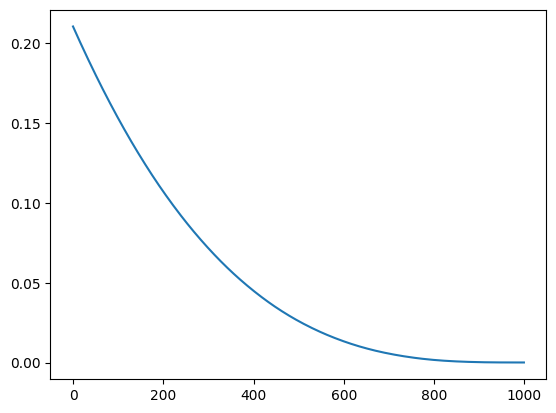

In [10]:
plt.plot(log_loss)